## Lectura de los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(22)
from tensorflow import set_random_seed
set_random_seed(47)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
%matplotlib inline

/home/abarsotti/Programming/VirtualEnv/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PICTURE_SIZE = 64
CHANNELS = 'RGB'
INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend([f'{color}{i}' for i in range(PICTURE_SIZE ** 2)])

In [3]:
NCOLS = 5
NROWS = 3
TITLE_PLOT_FONT_SIZE = 18

In [4]:
def show_images(samples, main_title, with_predictions=False):
    plt.figure(figsize=(16, 8))
    plt.tight_layout()
    plt.suptitle(main_title, fontsize=TITLE_PLOT_FONT_SIZE)
    plt.subplots_adjust(hspace=0.4)
    grid_index = 0
    
    for index, sample in samples.iterrows():
        if with_predictions:
            title_text = f"{sample['prediction']}: {sample['prediction_confidence']:.5f}%\n[{sample['fruit']}]" 
        else:
            title_text = sample['fruit']
        
        grid_index += 1
        plt.subplot(NROWS, NCOLS, grid_index)
        
        plt.title(title_text)

        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
            
        sample_as_grid = np.transpose(sample_as_grid) / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

    plt.show()

In [5]:
train = pd.read_csv('data/training.tar.xz', compression='xz')
train.rename(columns={'training.csv': 'R0', 'label': 'fruit'}, inplace=True)

test = pd.read_csv('data/validation.tar.xz', compression='xz')
test.rename(columns={'validation.csv': 'R0', 'label': 'fruit'}, inplace=True)

In [6]:
sets = (
    ('train', train),
    ('test', test),
)

## Variables

Las variables de entrada del dataset utilizado expresan la información de color de cada pixel de una imagen de una fruta. Dado que las imágenes tienen una dimensión de 64 x 64 píxeles, se tienen 4096 variables por cada canal de color. Los nombres de estas variables consisten en una letra que representa el canal de color y un número que indica su índice con base 0.

Además, se tiene la variable de salida "fruit" que corresponde al nombre de la fruta en cuestión.

## Etiquetas posibles

In [7]:
FRUITS = sorted(train.fruit.unique())
print(f'Existen {len(FRUITS)} etiquetas posibles en el dataset utilizado:')
for fruit in FRUITS:
    print(f'  - {fruit}')

Existen 64 etiquetas posibles en el dataset utilizado:
  - Apple Braeburn
  - Apple Golden 1
  - Apple Golden 2
  - Apple Golden 3
  - Apple Granny Smith
  - Apple Red 1
  - Apple Red 2
  - Apple Red 3
  - Apple Red Delicious
  - Apple Red Yellow
  - Apricot
  - Avocado
  - Avocado ripe
  - Banana
  - Banana Red
  - Cactus fruit
  - Cantaloupe 1
  - Cantaloupe 2
  - Carambula
  - Cherry 1
  - Cherry 2
  - Cherry Rainier
  - Clementine
  - Cocos
  - Dates
  - Granadilla
  - Grape Pink
  - Grape White
  - Grape White 2
  - Grapefruit Pink
  - Grapefruit White
  - Guava
  - Huckleberry
  - Kaki
  - Kiwi
  - Kumquats
  - Lemon
  - Lemon Meyer
  - Limes
  - Litchi
  - Mandarine
  - Mango
  - Maracuja
  - Nectarine
  - Orange
  - Papaya
  - Passion Fruit
  - Peach
  - Peach Flat
  - Pear
  - Pear Abate
  - Pear Monster
  - Pear Williams
  - Pepino
  - Pineapple
  - Pitahaya Red
  - Plum
  - Pomegranate
  - Quince
  - Raspberry
  - Salak
  - Strawberry
  - Tamarillo
  - Tangelo


## Ejemplos de imágenes del dataset

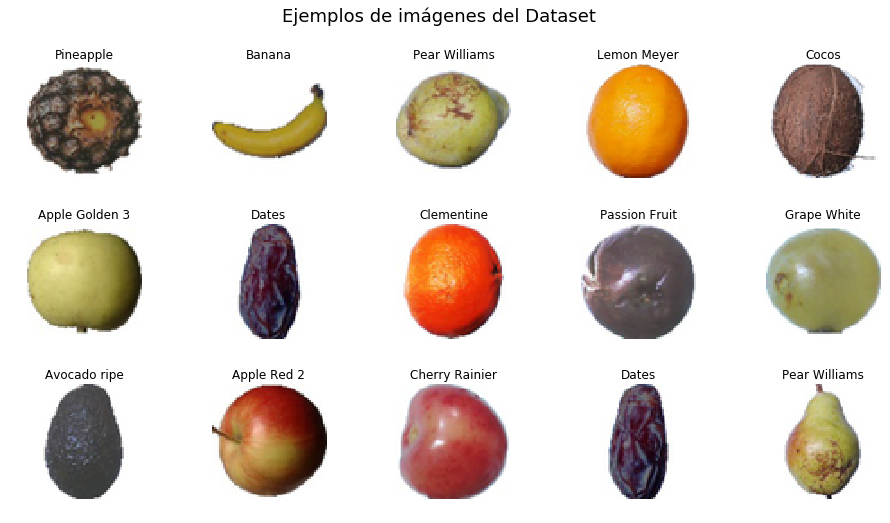

In [8]:
show_images(main_title='Ejemplos de imágenes del Dataset', samples=train.sample(NROWS*NCOLS))

## Volumetría de los datos

### Training

In [9]:
train.shape

(31688, 12290)

In [10]:
train

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B4088,B4089,B4090,B4091,B4092,B4093,B4094,B4095,fruit,path
0,255,255,255,255,255,255,254,251,253,254,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
2,251,255,255,255,252,249,251,254,255,253,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
3,255,250,251,255,255,254,253,254,255,245,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
4,253,250,253,255,255,253,253,255,255,251,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
5,255,252,248,249,254,255,255,253,251,250,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
6,254,254,254,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
7,255,255,252,251,254,255,255,254,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
8,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...


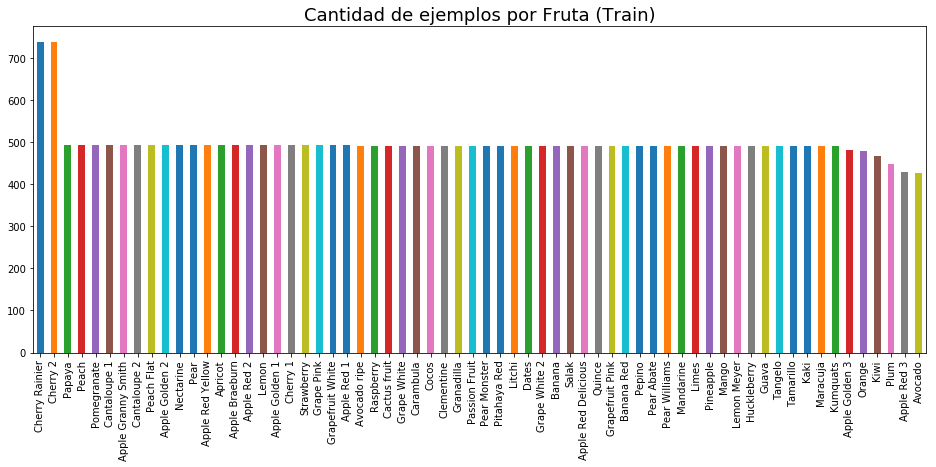

In [11]:
train.fruit.value_counts().plot.bar(figsize=(16,6))
plt.title('Cantidad de ejemplos por Fruta (Train)', fontsize=TITLE_PLOT_FONT_SIZE);

### Test

In [12]:
test.shape

(10657, 12290)

In [13]:
test

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B4088,B4089,B4090,B4091,B4092,B4093,B4094,B4095,fruit,path
0,252,254,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
3,255,255,255,255,254,254,254,254,254,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
5,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
6,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
7,255,249,248,255,255,254,251,254,255,252,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
8,255,255,253,251,251,253,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...


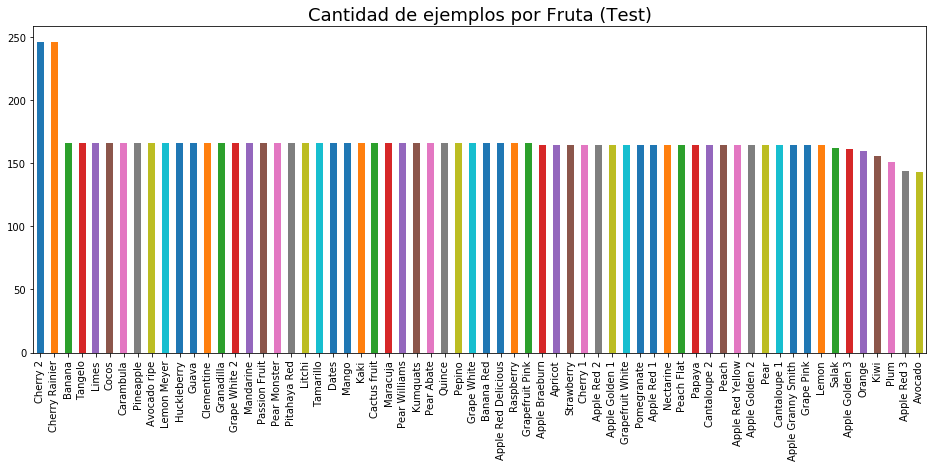

In [14]:
test.fruit.value_counts().plot.bar(figsize=(16,6))
plt.title('Cantidad de ejemplos por Fruta (Test)', fontsize=TITLE_PLOT_FONT_SIZE);

# Redes Neuronales

## Funciones

In [15]:
''' Extrae las columnas utilizadas como entrada para los modelos a entrenar. '''
def extract_inputs(dataset, convolutional=False):
    if not convolutional:
        return dataset[INPUT_COLUMNS].values / 255
    else:
        return dataset[INPUT_COLUMNS].values.reshape(len(dataset),
                    PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255

''' Extrae la columna utilizada como salida para los modelos a entrenar. '''
def extract_outputs(dataset):
    is_fruit_columns = [(dataset.fruit == fruit).values for fruit in FRUITS]
    return np.array(is_fruit_columns).T

In [16]:
'''Agrega tres columnas:
    - "prediction" con la predicción realizada por el modelo.
    - "prediction_confidence" con el valor devuelto por el modelo para dicha predicción.
    - "correct" indica si la predicción es correcta.'''
def add_predictions(dataset, model, convolutional=False):
    predictions = model.predict(extract_inputs(dataset, convolutional=convolutional))

    for fruit_number, fruit in enumerate(FRUITS):
        dataset[fruit] = predictions[:, fruit_number]
    
    dataset['prediction'] = dataset[FRUITS].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[FRUITS].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.fruit

## Red neuronal tradicional

In [17]:
nn_model = Sequential([
    Dense(500, activation='relu', input_shape=(len(INPUT_COLUMNS), )),
        
    Dense(250, activation='relu'),
        
    Dense(100, activation='relu'),
        
    Dense(len(FRUITS), activation='softmax'),
])

nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [18]:
nn_history = nn_model.fit(
    extract_inputs(train),
    extract_outputs(train),
    epochs=5,
    batch_size=160,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/5
31688/31688 [==============================] - 20s 623us/step - loss: 2.6456 - acc: 0.3187 - val_loss: 1.8470 - val_acc: 0.4155
Epoch 2/5
31688/31688 [==============================] - 19s 592us/step - loss: 0.5084 - acc: 0.8525 - val_loss: 0.7358 - val_acc: 0.7887
Epoch 3/5
31688/31688 [==============================] - 20s 617us/step - loss: 0.1956 - acc: 0.9460 - val_loss: 0.3812 - val_acc: 0.8985
Epoch 4/5
31688/31688 [==============================] - 19s 596us/step - loss: 0.0976 - acc: 0.9736 - val_loss: 0.5706 - val_acc: 0.8433
Epoch 5/5
31688/31688 [==============================] - 19s 593us/step - loss: 0.0908 - acc: 0.9719 - val_loss: 0.3468 - val_acc: 0.9096


### Accuracy a lo largo del entrenamiento

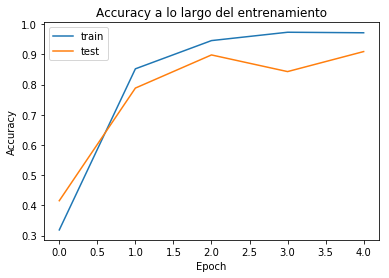

In [19]:
plt.plot(nn_history.history['acc'], label='train')
plt.plot(nn_history.history['val_acc'], label='test')
plt.title('Accuracy a lo largo del entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show();

### Matrices de confusión

######################### train #########################
Accuracy 0.9850732138348902


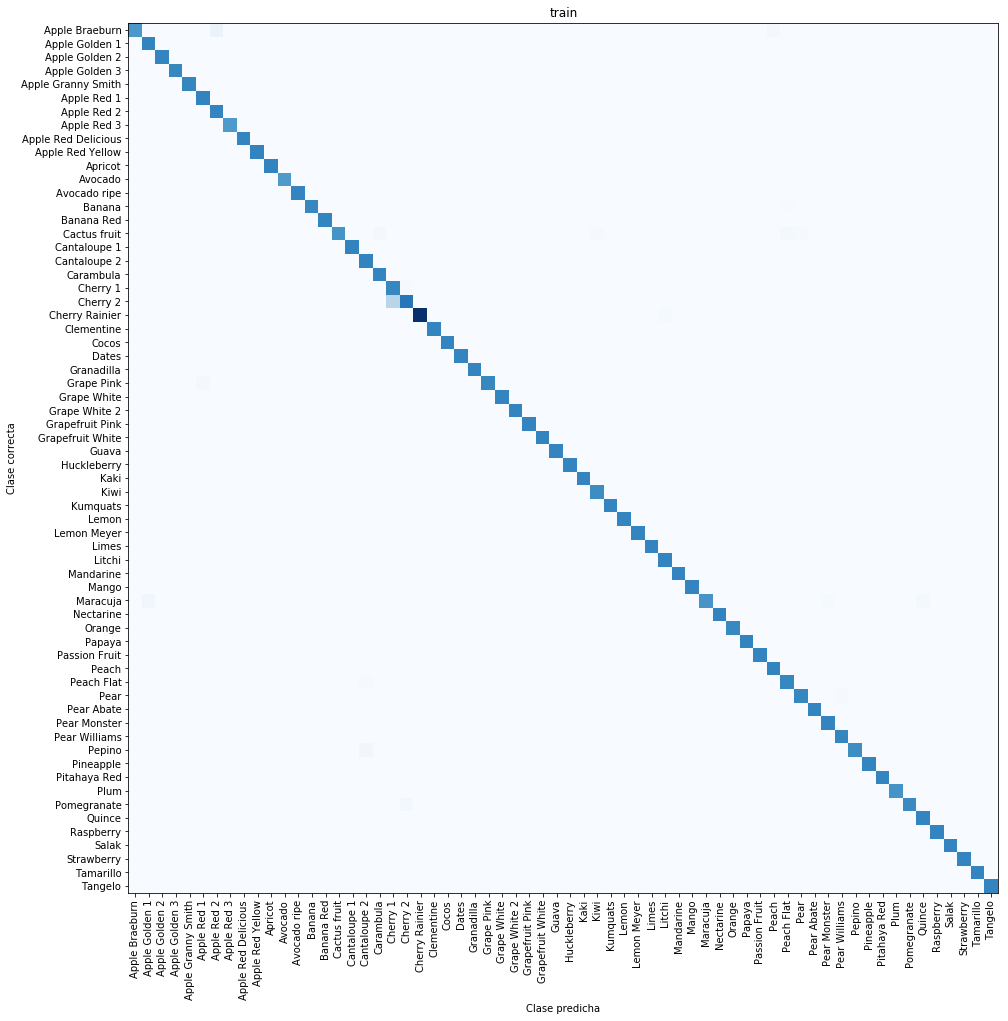

######################### test #########################
Accuracy 0.9096368584029276


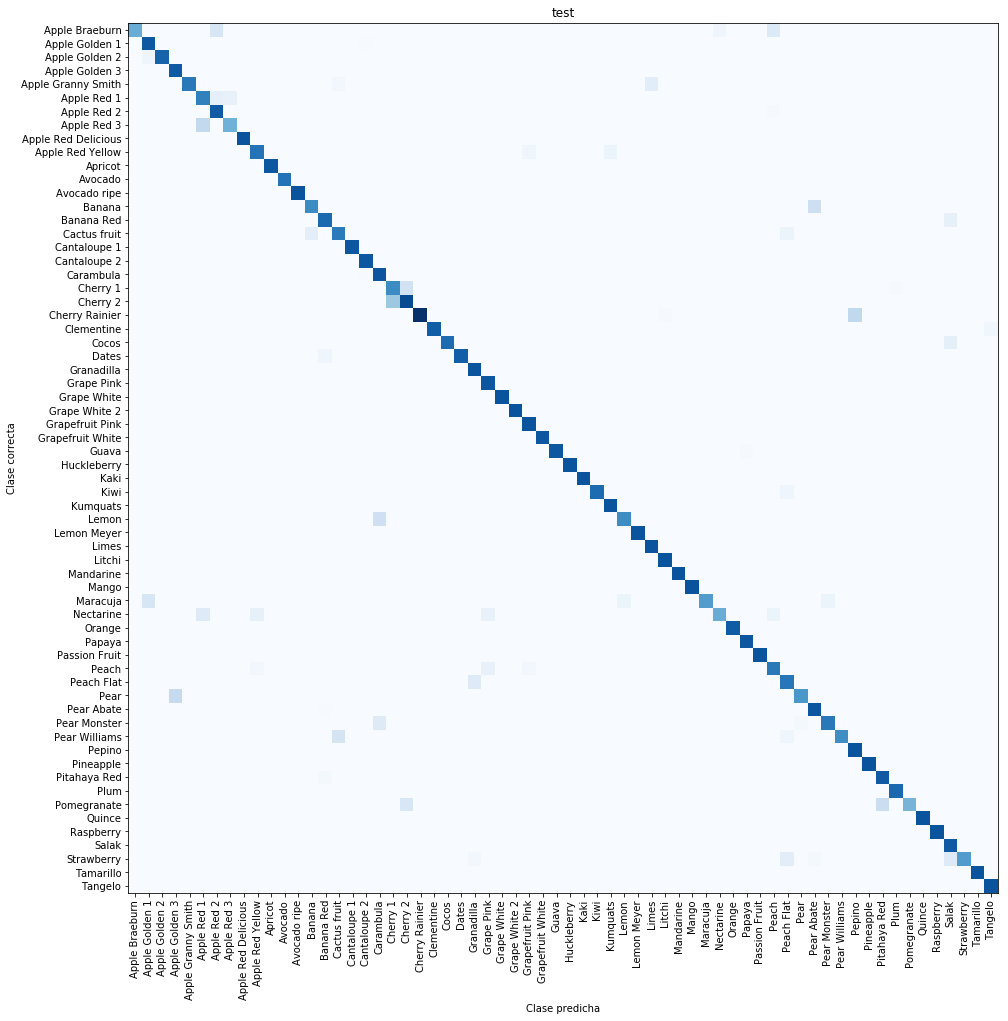

In [20]:
for set_name, set_data in sets:
    add_predictions(set_data, nn_model)
    
    print('#' * 25, set_name, '#' * 25)
    print('Accuracy', accuracy_score(set_data.fruit, set_data.prediction))
    #print('Precision:', precision_score(set_data.fruit, set_data.prediction, average='micro'))
    #print('Recall:', recall_score(set_data.fruit, set_data.prediction, average='micro'))

      
    plt.figure(figsize=(16,16))
    plt.xticks([x for x in range(len(FRUITS))], FRUITS, rotation=90)
    plt.yticks([x for x in range(len(FRUITS))], FRUITS)
    plt.xlabel('Clase predicha')
    plt.ylabel('Clase correcta')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

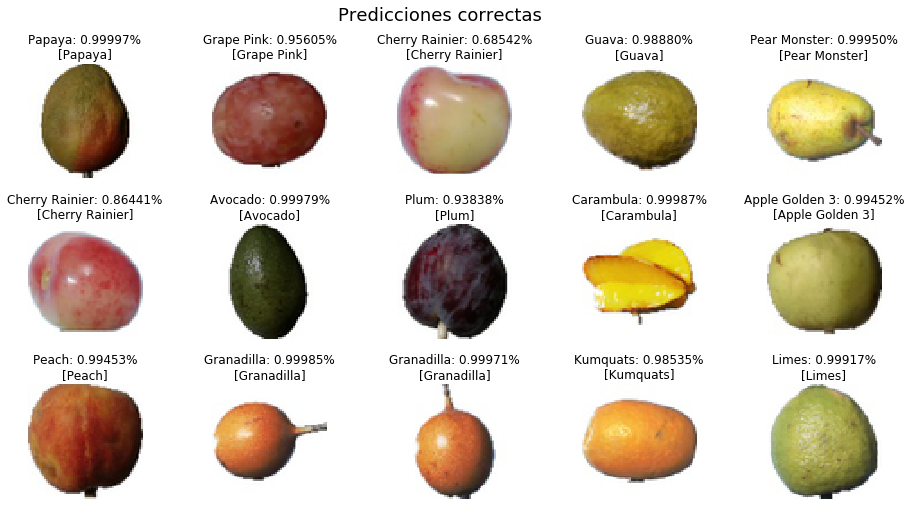

In [21]:
show_images(test[test.fruit == test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Predicciones correctas')

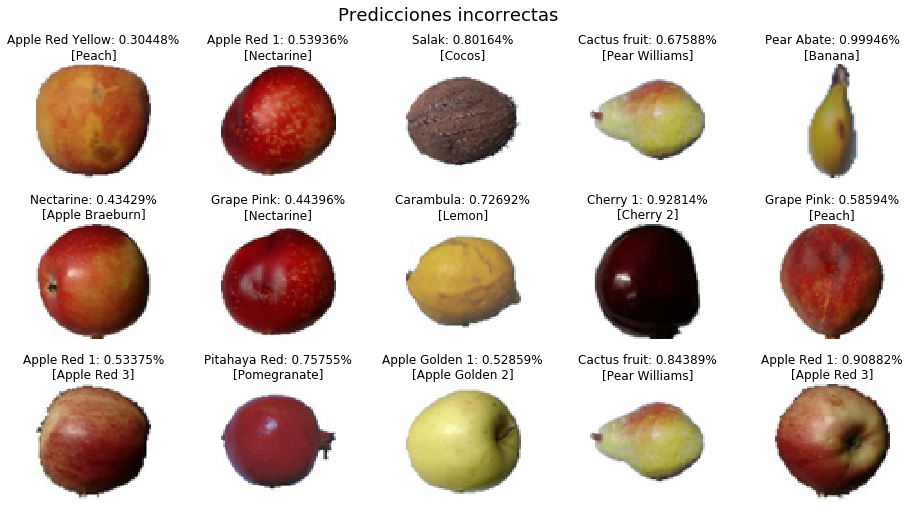

In [22]:
show_images(test[test.fruit != test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Predicciones incorrectas')

## Red neuronal convolucional

In [23]:
cnn_model = Sequential([
    Convolution2D(16, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
        
    MaxPooling2D(pool_size=(2, 2)),
            
    Convolution2D(8, (4, 4), activation='relu'),
        
    MaxPooling2D(pool_size=(2, 2)),
        
    Convolution2D(4, (4, 4), activation='relu'),
       
    Flatten(),
    
    Dense(256, activation='relu'),
        
    Dense(128, activation='relu'),
        
    Dense(len(FRUITS), activation='softmax'),
])


cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [24]:
cnn_history = cnn_model.fit(
    extract_inputs(train, convolutional=True),
    extract_outputs(train),
    epochs=5,
    batch_size=160,
    validation_data=(
        extract_inputs(test, convolutional=True),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/5
31688/31688 [==============================] - 20s 643us/step - loss: 1.3625 - acc: 0.6434 - val_loss: 0.5396 - val_acc: 0.8406
Epoch 2/5
31688/31688 [==============================] - 19s 615us/step - loss: 0.1684 - acc: 0.9529 - val_loss: 0.3108 - val_acc: 0.9085
Epoch 3/5
31688/31688 [==============================] - 19s 615us/step - loss: 0.0723 - acc: 0.9796 - val_loss: 0.1901 - val_acc: 0.9356
Epoch 4/5
31688/31688 [==============================] - 19s 615us/step - loss: 0.0513 - acc: 0.9840 - val_loss: 0.2043 - val_acc: 0.9382
Epoch 5/5
31688/31688 [==============================] - 20s 616us/step - loss: 0.0447 - acc: 0.9863 - val_loss: 0.1984 - val_acc: 0.9401


### Accuracy a lo largo del entrenamiento

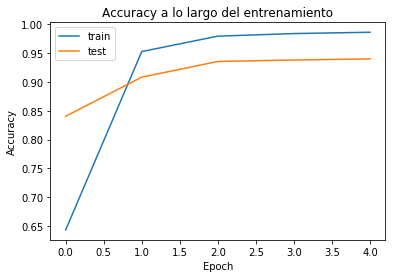

In [25]:
plt.plot(cnn_history.history['acc'], label='train')
plt.plot(cnn_history.history['val_acc'], label='test')
plt.title('Accuracy a lo largo del entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show();

### Matrices de confusión

######################### train #########################
Accuracy 0.9863670790204494


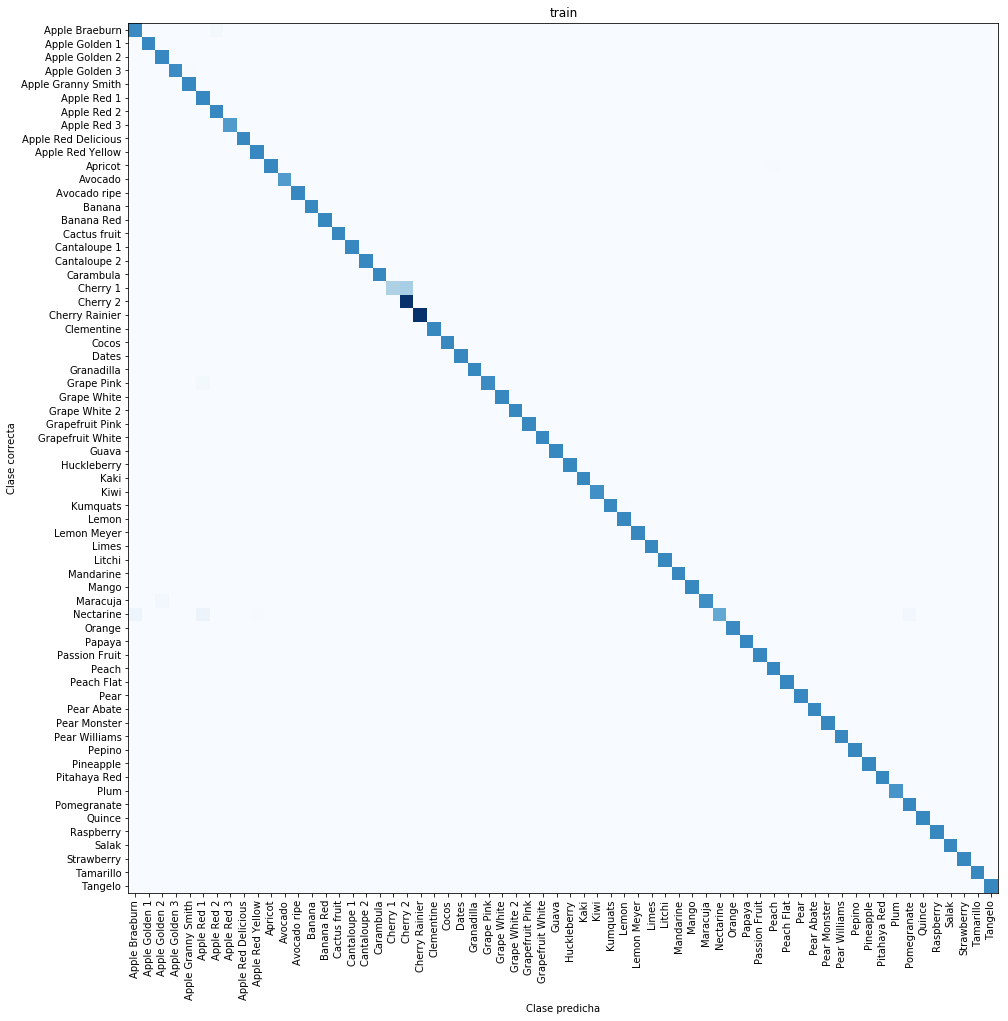

######################### test #########################
Accuracy 0.9401332457539645


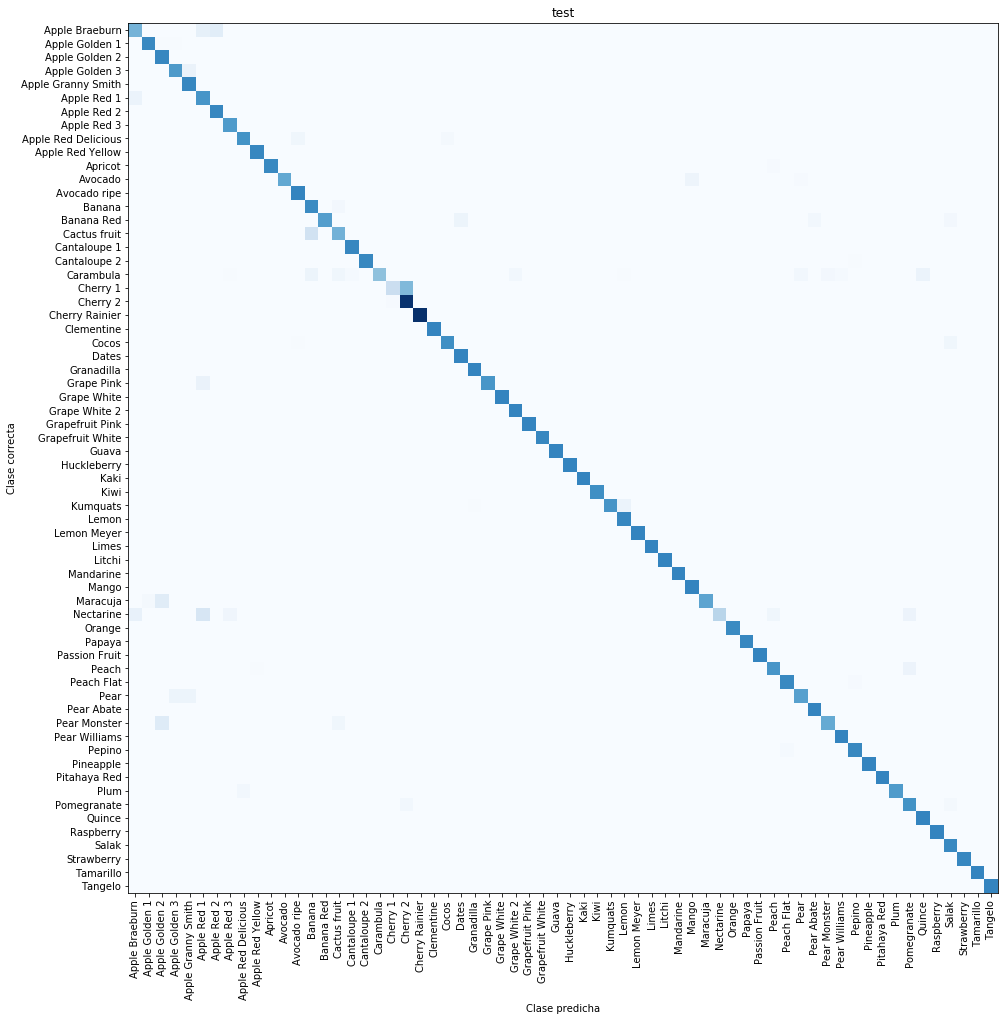

In [26]:
for set_name, set_data in sets:
    add_predictions(set_data, cnn_model, convolutional=True)
    
    print('#' * 25, set_name, '#' * 25)
    print('Accuracy', accuracy_score(set_data.fruit, set_data.prediction))
    #print('Precision:', precision_score(set_data.fruit, set_data.prediction, average='micro'))
    #print('Recall:', recall_score(set_data.fruit, set_data.prediction, average='micro'))

      
    plt.figure(figsize=(16,16))
    plt.xticks([x for x in range(len(FRUITS))], FRUITS, rotation=90)
    plt.yticks([x for x in range(len(FRUITS))], FRUITS)
    plt.xlabel('Clase predicha')
    plt.ylabel('Clase correcta')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

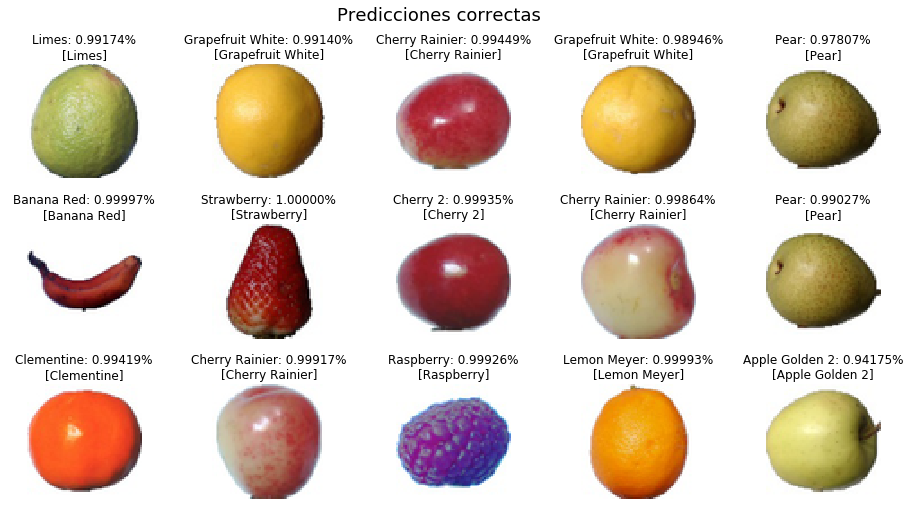

In [27]:
show_images(test[test.fruit == test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Predicciones correctas')

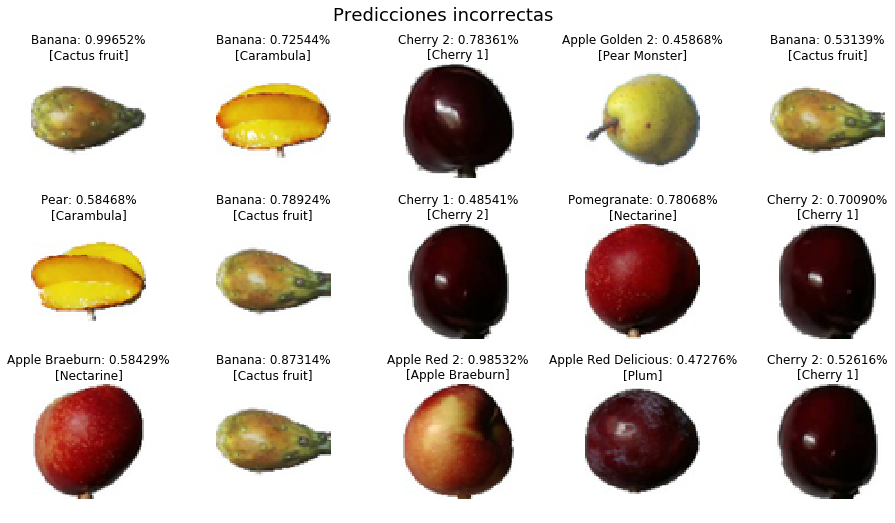

In [28]:
show_images(test[test.fruit != test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Predicciones incorrectas')